# Imports

In [1]:
# Imports
import xarray as xr
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import re

# Definitions

In [2]:
# Dictionaries for sorting months
month_to_num = {
    "Jan":1,
    "Feb":2,
    "Mar":3,
    "Apr":4,
    "May":5,
    "Jun":6,
    "Jul":7,
    "Aug":8,
    "Sep":9,
    "Oct":10,
    "Nov":11,
    "Dec":12,
}
num_to_month = {
    1:"Jan",
    2:"Feb",
    3:"Mar",
    4:"Apr",
    5:"May",
    6:"Jun",
    7:"Jul",
    8:"Aug",
    9:"Sep",
    10:"Oct",
    11:"Nov",
    12:"Dec",
}

In [3]:
# To sort months
def get_month_num_from_name(file_name: str) -> int:
    """
    Functional key to sort months in the heatmap. Gets the month name from the file name and returns 
    the month number for sorting.

    Parameters:
        file_name (str): File name of the file whose data is being read.
    
    Returns:
        month_number (int): The number of the month in the file name.
    """
    match = re.match(r'([A-Za-z]{3})IC_.*\.nc', file_name)
    if match:
        month_abbr = match.group(1)
        return month_to_num.get(month_abbr, 0) #default to 0 for debugging
    return 0

In [ ]:
def focused_year_skill(model_name: str, latitude: float, longitudes: list[float]) -> None:
    """
    Processes and plots a model's skill across the year in a line plot for a list 
    of longitudes in the file at a single latitude and their mean skill value. 
    Saves the plots.

    Parameters:
        model_name (str): Name of the model to be plotted.
        latitude (float): Desired latitude at wich to plot the skill.
        longitudes (list[float]): A list of desired longitudes at wich to plot the skill.
    """
    # Directory where this model's .nc files are located
    input_dir = f"../2m_air_temperature/monthly/{model_name}/converted/"
    # input_dir = f"../2m_air_temperature/seasonal/{model_name}/converted/"
    # input_dir = f"../precipitation/monthly/{model_name}/converted/"
    # input_dir = f"../precipitation/seasonal/{model_name}/converted/"
    # input_dir = f"../sea_surface_temperature/monthly/{model_name}/converted/"
    # input_dir = f"../sea_surface_temperature/seasonal/{model_name}/converted/"


    all_monthly_datasets = []
    current_year = 2025

    # List of netCDF files in the directory
    nc_files = [file for file in os.listdir(input_dir) if file.endswith(".nc")]

    # Functional key for sorting based on month
    nc_files.sort(key=get_month_num_from_name)

    for filename in nc_files:
        filepath = os.path.join(input_dir, filename)

        month_abbr_match = re.match(r'([A-Za-z]{3})IC_.*\.nc', filename)
        # Debugging print
        if not month_abbr_match:
            print(f"Could not match month abbreviation from '{filename}'.")
            continue

        month_abbr = month_abbr_match.group(1)
        month_num = month_to_num.get(month_abbr)

        # Debugging print
        if month_num is None:
            print(f"No number for month '{month_abbr}'. check dictionary.")
            continue

        try:
            #open file like in "to_open_netcdf.ipynb"
            ds = xr.open_dataset(filepath, decode_times=False)

            # Converting to pandas datetime the first day of the month
            correct_time = pd.to_datetime(f"{current_year}-{month_num}-01")

            # Update the dataset time
            ds = ds.assign_coords(time=[correct_time])

            # Finished processing
            all_monthly_datasets.append(ds)
        
        except Exception as e:
            print(f"Error processing '{filename}': {e}.")

    # Debugging stop
    if not all_monthly_datasets:
        raise ValueError(f"No files were processed for {model_name}.")

    # Concatenate datasets by time
    dataset = xr.concat(all_monthly_datasets, dim="time")

    # Converting longitudes to -180 to 180 format
    dataset = dataset.assign_coords(lon=(dataset['lon'] + 180) % 360 - 180)
    dataset = dataset.sortby('lon')

    # Adding month_name coordinate
    month_names = [num_to_month[month_num] for month_num in dataset['time'].dt.month.values]

    # Making sure months are in order
    month_order = [num_to_month[i] for i in sorted(num_to_month.keys())]
    month_names_categorical = pd.Categorical(month_names, categories=month_order, ordered=True)
    dataset = dataset.assign_coords(month_name=('time', month_names_categorical))

    # Debugging print
    # print("Combined dataset:", dataset, "\n", sep="\n")

    try:
        # Selecting latitude and longitudes
        ds_at_lat = dataset.sel(lat=latitude, lon=slice(longitudes[0], longitudes[-1]))
    except KeyError as ke:
        raise ValueError(f"Given coordinates not found in dataset for {model_name}. {ke}.")
    
    
    #### PLOTTING LINE PLOT PER LONGITUDE #####
    plt.figure(figsize=(14,7))
    sk1_data = ds_at_lat['sk1']

    # Debugging print
    # print(sk1_data)

    # Mean skill to visually compare models
    # .squeeze() to handle the singleton lat va;ue
    sk1_mean = sk1_data.mean(dim="lon").squeeze()

    for lon_val in sk1_data['lon'].values:
        # squeeze() to remove latitude dimension because it is a singleton at the moment
        line_data = sk1_data.sel(lon=lon_val, method='nearest').squeeze()
        plt.plot(line_data['month_name'], line_data, label=f'Lon: {lon_val:.1f}', linewidth=1)

    plt.plot(sk1_mean['month_name'], sk1_mean, label="Mean Skill", color="black", linestyle="-", linewidth=2)

    # Change 'Monthly' to 'Seasonal (3 month)' if needed
    plt.title(f"{model_name} Monthly 2m Air Temperature Lead-1 Skill")
    plt.xlabel("Time")
    plt.ylabel("Lead-1 Skill")
    plt.legend(title="Longitudes and Mean")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.yticks(np.arange(-0.6, 1.0, 0.1))
    plt.tight_layout()

    # Change if Monthly or Seasonal
    # plt.savefig(f"../precipitation/monthly/plots/line_plots/{model_name} Monthly Surface Precipitation Lead-1 Skill.png")
    plt.savefig(f"../precipitation/seasonal/plots/line_plots/{model_name} Seasonal Surface Precipitation Lead-1 Skill.png")

    print(f"Plotted Year long seasonal skill for {model_name}.")

# Call

Plotted Year long seasonal skill for CanCM4i (CMC1).
Plotted Year long seasonal skill for CCSM4.
Plotted Year long seasonal skill for CESM1.
Plotted Year long seasonal skill for CFSv2.
Plotted Year long seasonal skill for GEM-NEMO (CMC2).
Plotted Year long seasonal skill for GEOS-5 (NASA).
Plotted Year long seasonal skill for NMME.


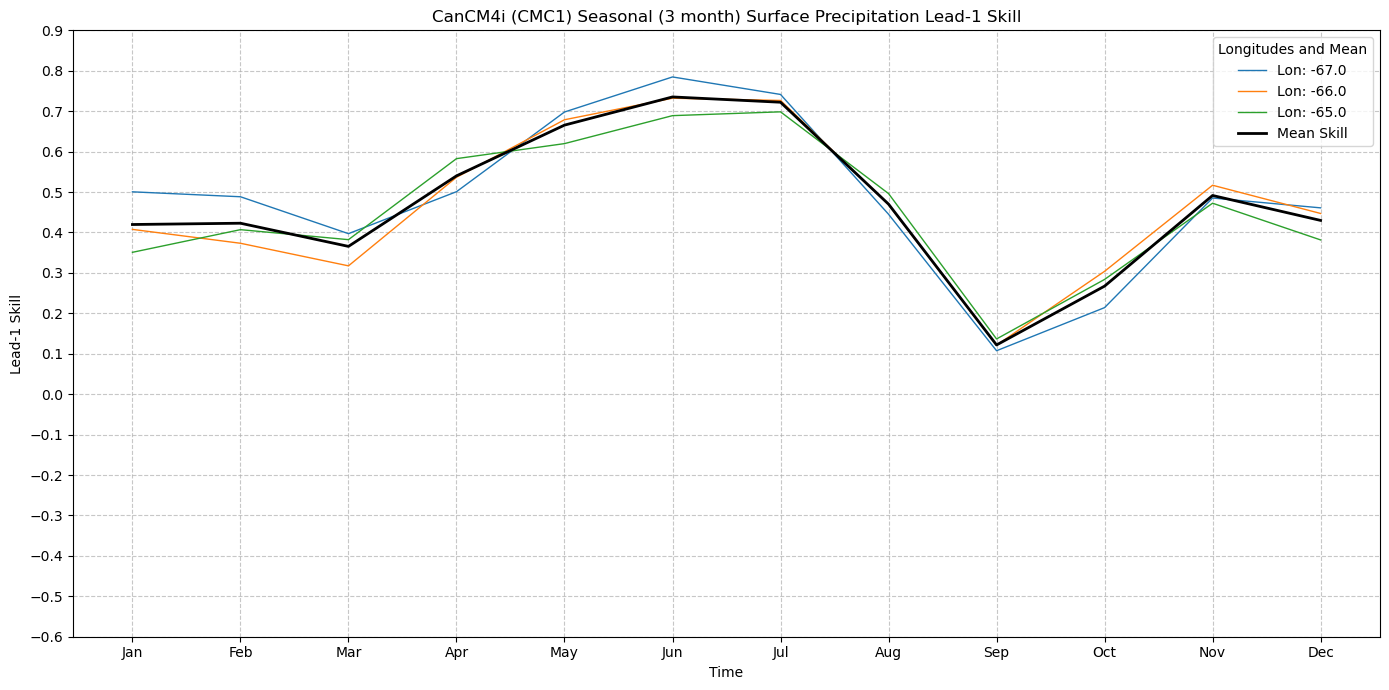

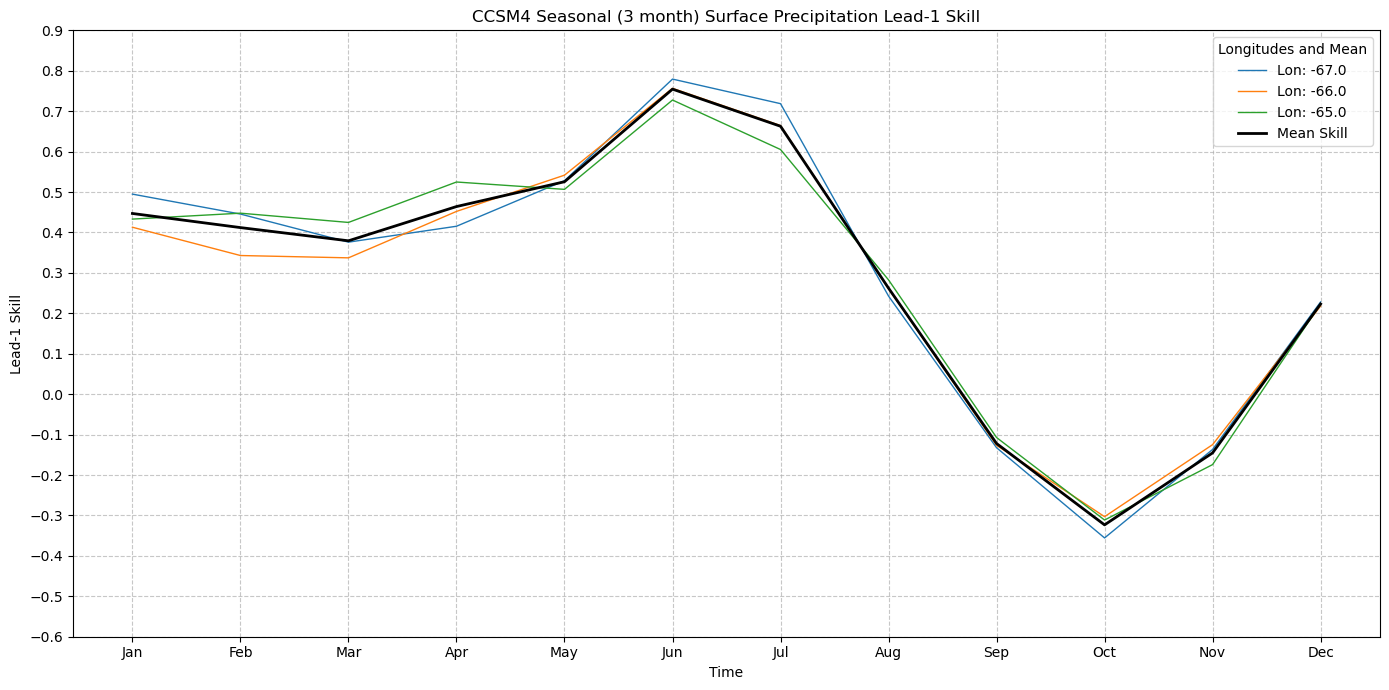

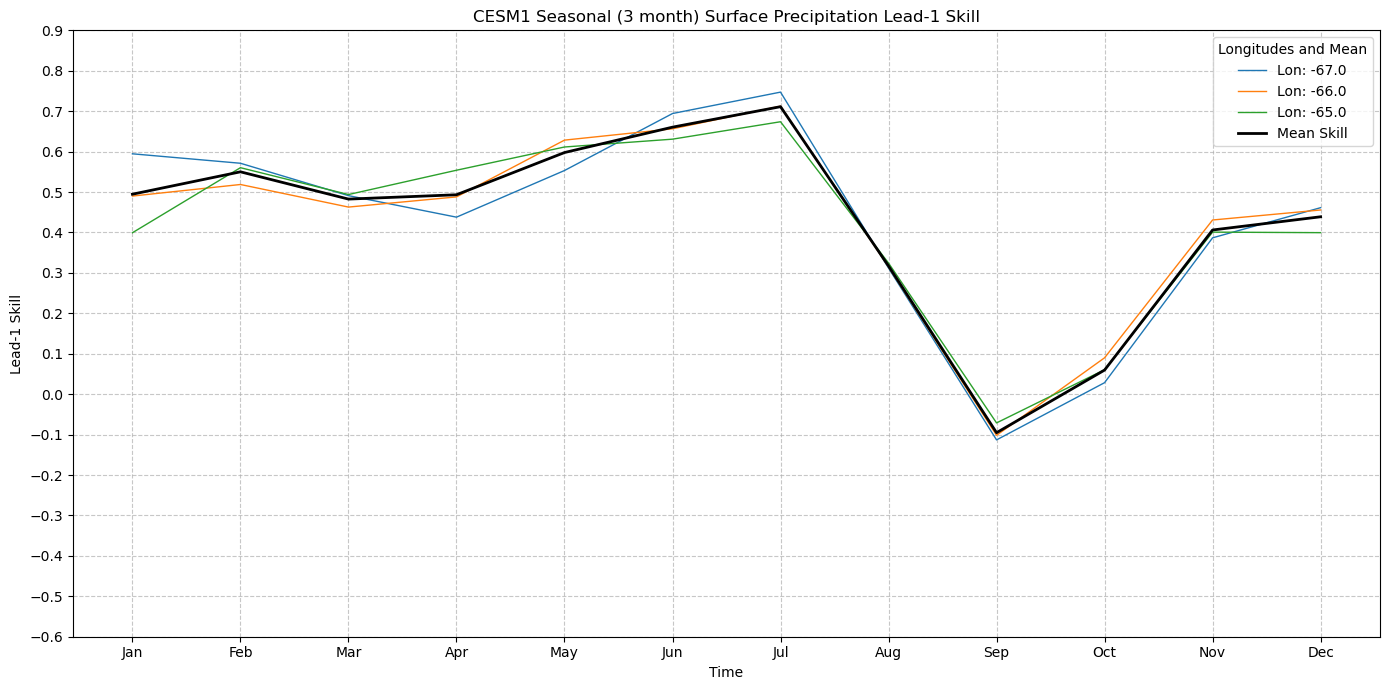

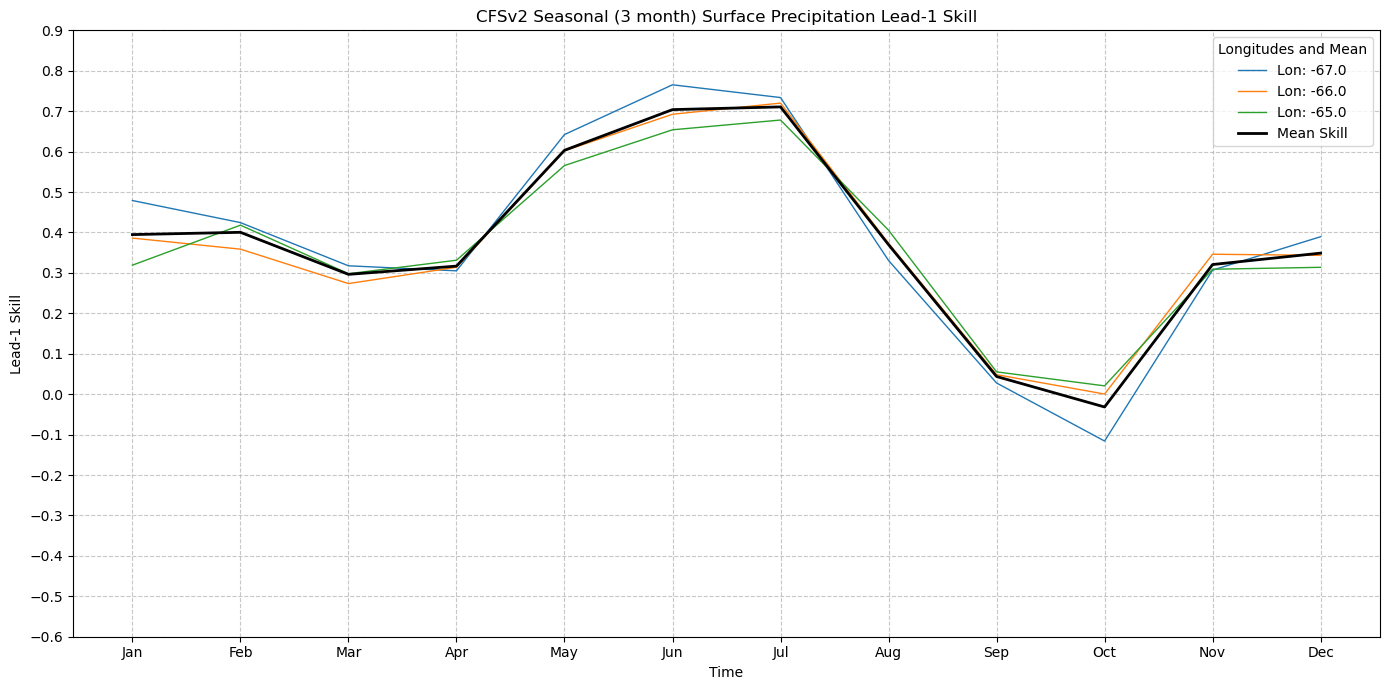

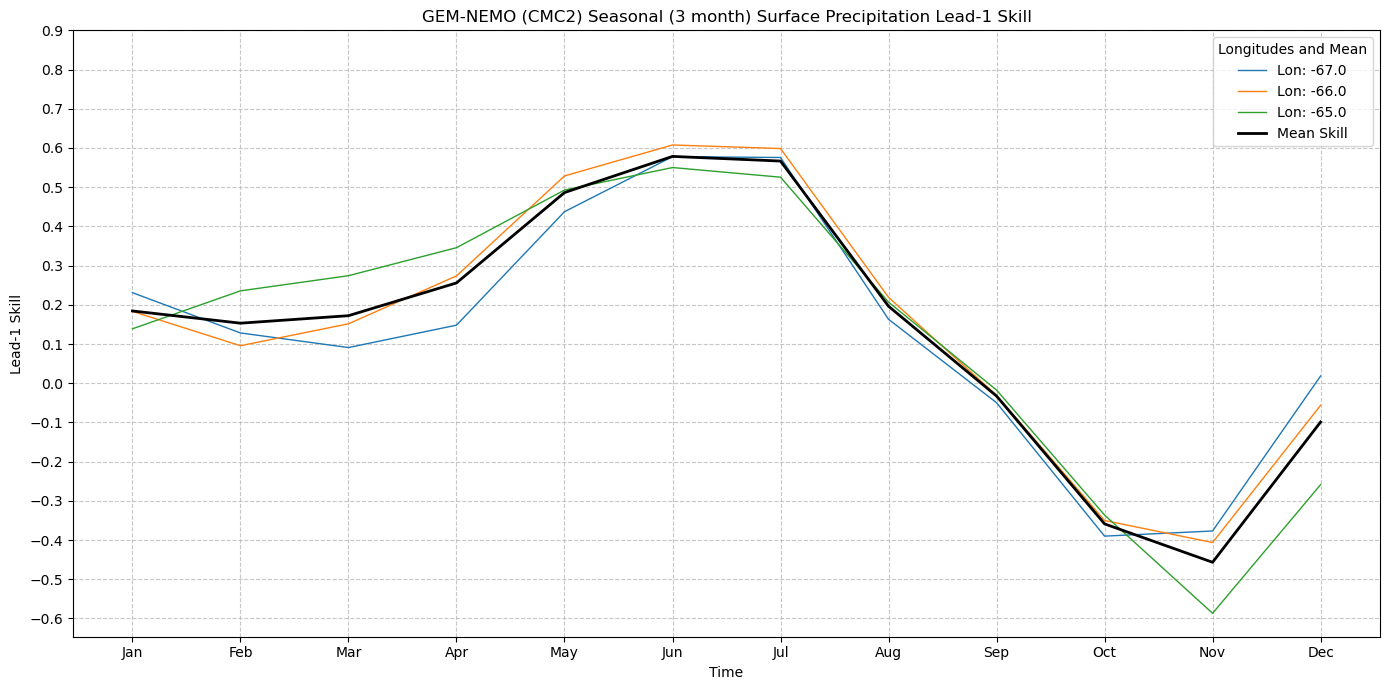

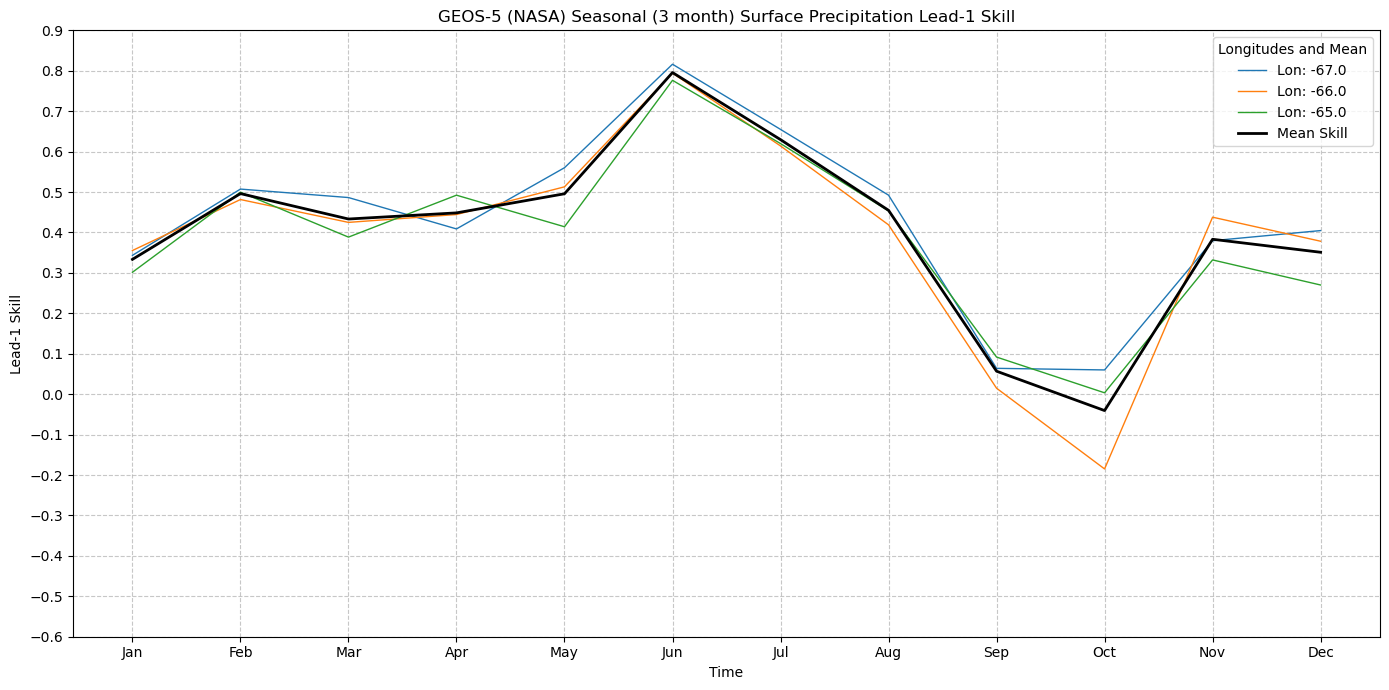

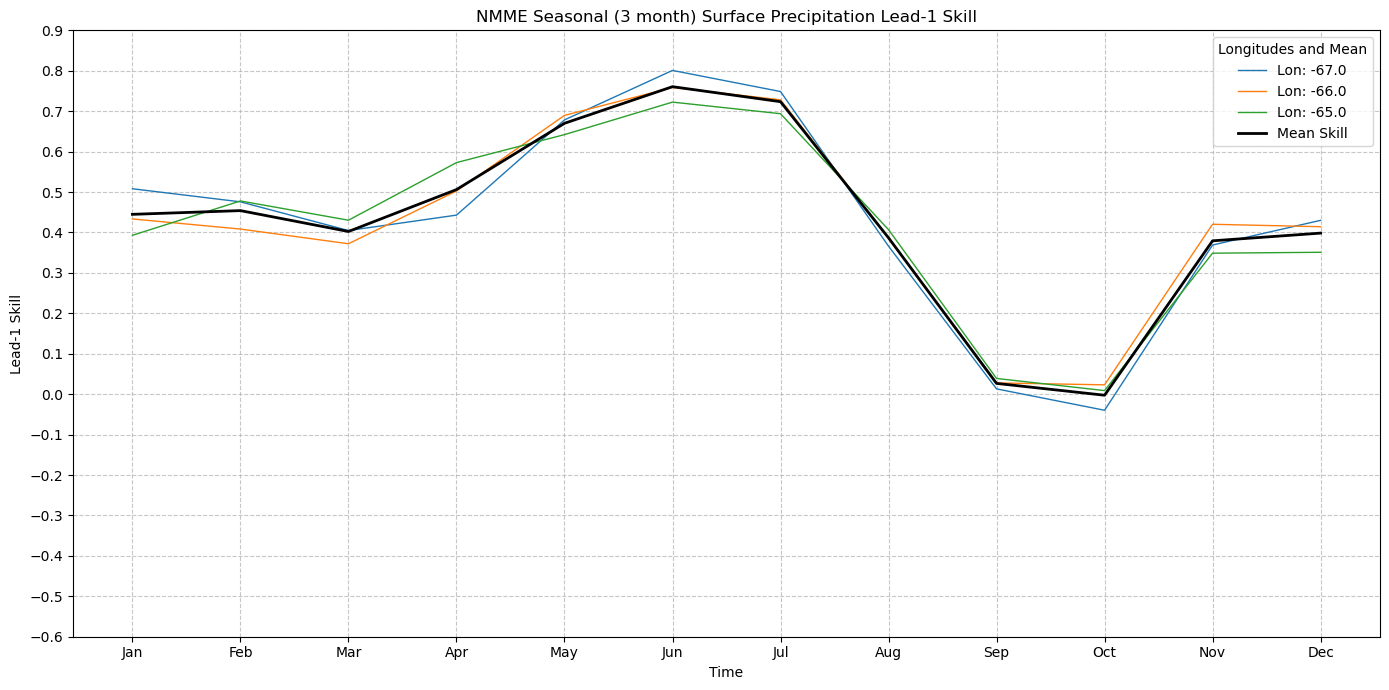

In [43]:
# Call
for model_name in ["CanCM4i (CMC1)", "CCSM4", "CESM1", "CFSv2", "GEM-NEMO (CMC2)", "GEOS-5 (NASA)", "NMME"]:
    focused_year_skill(model_name, 18.0, [-67.0, -66.0, -65.0])